In [45]:
# NB: the recommended way to run isoclassify is through the command-line interface (CLI)
# using examples such as given in examples/examples.csv (see README)
# below is an example to run isoclassify from ipython, which for now requires some hacking by 
# pre-defining functions but allows direct interaction with posteriors. 

In [1]:
# required packages
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os 
import copy
import glob
import h5py,pdb

import numpy as np
from matplotlib import pylab as plt
import pandas as pd
import ebf
import astropy.units as units
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarWebQuery
import mwdust

from isoclassify.direct import classify as classify_direct
from isoclassify.grid import classify as classify_grid
from isoclassify import DATADIR


In [2]:
# the following functions required for this

def query_dustmodel_coords(ra,dec):
    reddenMap = BayestarWebQuery(version='bayestar2017')
    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='icrs')
    reddenContainer = reddenMap(sightLines,mode='best')
    del reddenMap # To clear reddenMap from memory
    distanceSamples = np.array([0.06309573,0.07943284,0.1,0.12589255,0.15848933,0.19952627,0.25118864,0.31622776,0.3981072,0.50118726,0.6309574,0.7943282 ,1.,1.2589258,1.5848933,1.9952621,2.511887,3.1622777,3.981073,5.011873,6.3095727,7.943284,10.,12.589258,15.848933,19.952621,25.11887,31.622776,39.81073,50.11873,63.095726])*1000. # In pc, from bayestar2017 map distance samples
    
    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})

    for index in xrange(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]
        
    return dustModelDF
    
def query_dustmodel_coords_allsky(ra,dec):
    reddenMap = mwdust.Combined15()
    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='galactic')
    distanceSamples = np.array([0.06309573,0.07943284,0.1,0.12589255,0.15848933,0.19952627,0.25118864,0.31622776,0.3981072,0.50118726,0.6309574,0.7943282 ,1.,1.2589258,1.5848933,1.9952621,2.511887,3.1622777,3.981073,5.011873,6.3095727,7.943284,10.,12.589258,15.848933,19.952621,25.11887,31.622776,39.81073,50.11873,63.095726])*1000. # In pc, from bayestar2017 map distance samples
    reddenContainer=reddenMap(sightLines.l.value,sightLines.b.value,distanceSamples/1000.)
    del reddenMap # To clear reddenMap from memory
    
    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})
    
    for index in xrange(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

    return dustModelDF

def extinction(law):
    if (law == 'cardelli'):
        out = {
            "ab":4.1708789, 
            "av":3.1071930, 
            "abt":4.3358221, 
            "avt":3.2867038, 
            "ag":3.8281101, 
            "ar":2.7386468, 
            "ai":2.1109662, 
            "az":1.4975613, 
            "aj":0.89326176, 
            "ah":0.56273418, 
            "ak":0.35666104, 
            "aga":2.4623915
        }
        
    if (law == 'schlafly11'):
        out = {
            "ab":3.626, 
            "av":2.742, 
            "abt":4.5309214, 
            "avt":3.1026801, 
            "ag":3.303, 
            "ar":2.285, 
            "ai":1.698, 
            "az":1.263, 
            "aj":0.77510388, 
            "ah":0.50818384, 
            "ak":0.33957048, 
            "aga":1.9139634
        }

    if (law == 'schlafly16'):
        # see http://argonaut.skymaps.info/usage under "Gray Component". this is a lower limit.
        grayoffset=0.063
        out = {
            "ab":3.6060565+grayoffset, 
            "av":2.9197679+grayoffset, 
            "abt":3.7204173+grayoffset, 
            "avt":3.0353634+grayoffset, 
            "ag":3.384+grayoffset, 
            "ar":2.483+grayoffset, 
            "ai":1.838+grayoffset, 
            "az":1.414+grayoffset, 
            "aj":0.650+grayoffset, 
            "ah":0.327+grayoffset, 
            "ak":0.161+grayoffset, 
            "aga":2.2203186+grayoffset
        }
    return out


In [3]:
# load BC model
fn = os.path.join(DATADIR,'bcgrid.h5')
bcmodel = h5py.File(fn,'r', driver='core', backing_store=False)

In [7]:
# if we want to use a reddening map, we'll need to add coordinates
x = classify_direct.obsdata()
x.addcoords(243.9052932171665,-08.3694394)

In [8]:
# if we don't want to use a reddening map, isoclassify fits for Av. However, we need to 
# define an extinction law
dustmodel = query_dustmodel_coords_allsky(x.ra,x.dec)
ext = extinction('cardelli')

In [9]:
# define class that contains observables
x = classify_direct.obsdata()

In [10]:
# add [Teff, logg, FeH] and [sigma_Teff, sigma_logg, sigma_FeH] 
x.addspec([5777.,4.44,0.0],[60.,0.07,0.04])

In [11]:
# now let's add some more observables, e.g. a parallax 
x.addplx(0.07,0.007)

In [12]:
# and some JHK photometry
x.addjhk([4.38,4.04,4.00],[0.03,0.03,0.03])

In [13]:
# photometry to use for distance modulus. Jmag here
x.addmag([4.38],[0.03])

('using max distance:', 24.0)
('using min distance:', 10.0)
   
('teff(K):', 5777.0, '+/-', 60.0)
('dis(pc):', 14.90508905089051, '+', 1.7619176191761916, '-', 1.4246542465424668)
('av(mag):', 0.0036773969033659232, '+', 0.00043470189105359811, '-', 0.00035149197007242061)
('rad(rsun):', 1.0676653023461999, '+', 0.12957444917558636, '-', 0.10572658701936888)
('lum(lsun):', 1.1401751475431277, '+', 0.28743033281381858, '-', 0.2104102525117123)
('mabs(', 'jmag', '):', 3.5116354514903056, '+', 0.2214957041032517, '-', 0.24409111221703927)
-----


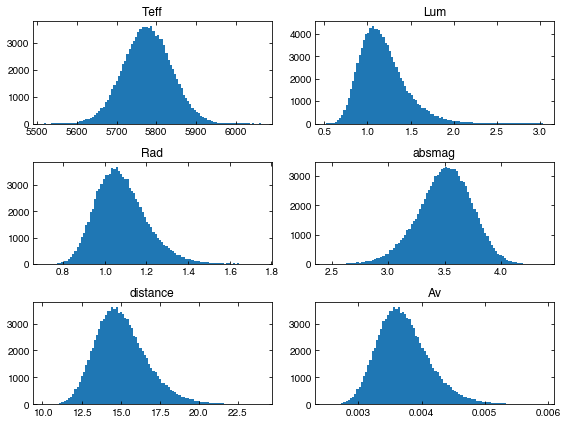

In [14]:
# redo fit, this time using the dustmodel
# perform classification
paras = classify_direct.stparas(input=x, bcmodel=bcmodel, dustmodel=dustmodel,band='jmag', ext=ext, plot=1)

In [18]:
paras.dis

14.90508905089051

In [35]:
paras.rad

1.0676653023462